# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors.
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model.
1. Learn how to deploy and use a text model on CAIP.



## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-02-74c800cc1cb2"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "us-central1"  

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [5]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,http://macdailynews.com/index.php/weblog/comme...,Apple now worth double Dell's market value,11
1,http://54.247.181.15/,Show HN: Conway's Game of Life JS implementation,11
2,http://tumult.com/hype/pro/,Show HN: Hype Pro uses Matter.js for Physics a...,12
3,http://grumpy-testing.com,The Grumpy Programmer's Guide To Building Test...,12
4,http://www.theregister.com/2007/07/28/meraki_f...,Startup brings free wifi to SF,12
5,http://myfaves.fm,Show HN: myfaves.fm – A flat-ui music player b...,12
6,http://getdropbox.com/,DropBox out of space?,12
7,http://www.theamericanscholar.org/solitude-and...,Solitude and Leadership,13
8,https://unschooler.me/skills/,Show HN: Unschooler predicts future career by ...,14
9,http://blog.cartodb.com/post/83723812630/moves...,"Your Moves moves, visualized",14


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [6]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,139395
1,medium,125985
2,youtube,101025
3,nytimes,73114
4,blogspot,59863
...,...,...
95,nextplatform,2647
96,anandtech,2629
97,extremetech,2598
98,politico,2594


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [11]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [13]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,organize and iterate on javascript templates f...,github
1,new java implementation of github api,github
2,show the business how new web projects should ...,github
3,show hn do not type same commands,github
4,useful vim resources,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [14]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 266442 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [15]:
title_dataset.source.value_counts()

github        139395
nytimes        73114
techcrunch     53933
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [16]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [17]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [18]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        521
nytimes       274
techcrunch    205
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [19]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [20]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.5


In [21]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [22]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [23]:
ls ./data/

titles_full.csv  titles_sample.csv


In [24]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,kubernetes production patterns and anti-patterns,github
1,which metrics matter for today s app developers,techcrunch
2,52 places to go in 2017,nytimes
3,transparency open source gplv2 user activit...,github
4,qgis server plugin to add ogc web processing s...,github


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [25]:
titles_df.source.value_counts()

github        139395
nytimes        73114
techcrunch     53933
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [26]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [27]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [22]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [28]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [29]:
sources_train.value_counts()

github        132360
nytimes        69472
techcrunch     51287
Name: source, dtype: int64

In [30]:
sources_valid.value_counts()

github        7035
nytimes       3642
techcrunch    2646
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [32]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [33]:
X_train[:3]

array(['kubernetes production patterns and anti-patterns',
       'which metrics matter for today s app developers ',
       '52 places to go in 2017'], dtype=object)

In [35]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [36]:
# TODO 1
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

2023-12-08 16:45:59.749504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-08 16:45:59.749558: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-08 16:45:59.749589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20231209-004742): /proc/driver/nvidia/version does not exist
2023-12-08 16:45:59.750013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [37]:
# TODO 1
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [38]:
# TODO 1
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [39]:
# TODO 1
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [40]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO 2
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [41]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=TensorBoard(model_dir),
    )
    return history

## Training NNLM

In [42]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [43]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2023-12-08 16:47:09.085868: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-08 16:47:09.086085: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-12-08 16:47:09.089894: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 1/51 [..............................] - ETA: 59s - loss: 1.1123 - accuracy: 0.3088

2023-12-08 16:47:10.419766: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-08 16:47:10.420422: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/51 [>.............................] - ETA: 29s - loss: 1.1055 - accuracy: 0.3269

2023-12-08 16:47:11.014179: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-12-08 16:47:11.016809: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-12-08 16:47:11.028183: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2023_12_08_16_47_11

2023-12-08 16:47:11.029873: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/nnlm/train/plugins/profile/2023_12_08_16_47_11/instance-20231209-004742.trace.json.gz
2023-12-08 16:47:11.043113: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2023_12_08_16_47_11

2023-12-08 16:47:11.043544: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./text_models/nnlm/train/plugins/profile/2023_12_08_16_47_

51/51 [==============================] - 31s 604ms/step - loss: 0.8885 - accuracy: 0.6441 - val_loss: 0.6467 - val_accuracy: 0.7711
Epoch 2/50
51/51 [==============================] - 31s 605ms/step - loss: 0.4989 - accuracy: 0.8215 - val_loss: 0.3971 - val_accuracy: 0.8545
Epoch 3/50
51/51 [==============================] - 30s 591ms/step - loss: 0.3404 - accuracy: 0.8749 - val_loss: 0.3218 - val_accuracy: 0.8759
Epoch 4/50
51/51 [==============================] - 30s 597ms/step - loss: 0.2804 - accuracy: 0.8944 - val_loss: 0.2937 - val_accuracy: 0.8844
Epoch 5/50
51/51 [==============================] - 31s 604ms/step - loss: 0.2486 - accuracy: 0.9062 - val_loss: 0.2822 - val_accuracy: 0.8891
Epoch 6/50
51/51 [==============================] - 31s 615ms/step - loss: 0.2277 - accuracy: 0.9141 - val_loss: 0.2767 - val_accuracy: 0.8928
Epoch 7/50
51/51 [==============================] - 31s 602ms/step - loss: 0.2126 - accuracy: 0.9203 - val_loss: 0.2756 - val_accuracy: 0.8942
Epoch 8/50

<AxesSubplot: >

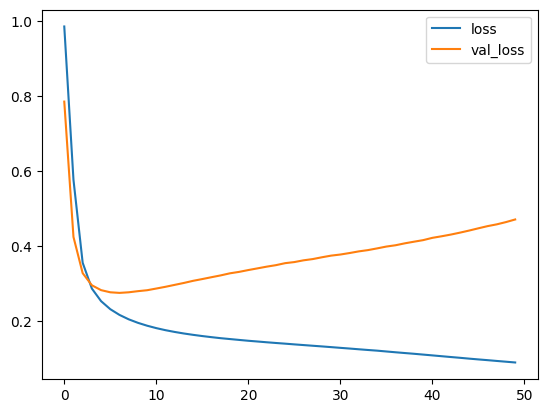

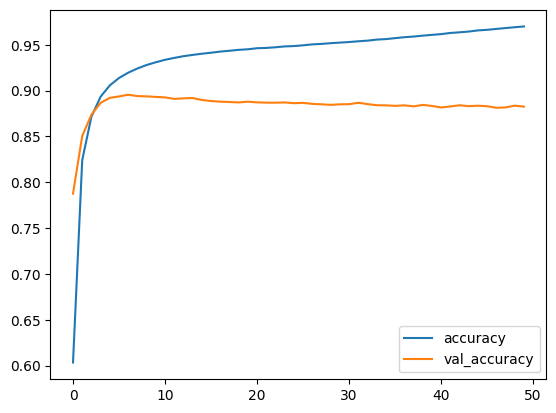

In [38]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [46]:
swivel_model = build_model(swivel_module, name='swivel')

In [47]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

2023-12-08 17:27:11.334694: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-08 17:27:11.334925: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-12-08 17:27:11.335149: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 6/51 [==>...........................] - ETA: 1s - loss: 1.3264 - accuracy: 0.2761

2023-12-08 17:27:11.941872: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-08 17:27:11.941943: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-12-08 17:27:12.003796: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-12-08 17:27:12.005403: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-12-08 17:27:12.007820: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugins/profile/2023_12_08_17_27_12

2023-12-08 17:27:12.009077: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/swivel/train/plugins/profile/2023_12_08_17_27_12/instance-20231209-004742.trace.json.gz
2023-12-08 17:27:12.010979: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugin

51/51 [==============================] - 2s 29ms/step - loss: 1.0795 - accuracy: 0.4521 - val_loss: 0.8909 - val_accuracy: 0.6119
Epoch 2/50
51/51 [==============================] - 1s 25ms/step - loss: 0.8134 - accuracy: 0.6495 - val_loss: 0.7383 - val_accuracy: 0.6848
Epoch 3/50
51/51 [==============================] - 1s 25ms/step - loss: 0.6781 - accuracy: 0.7171 - val_loss: 0.6199 - val_accuracy: 0.7435
Epoch 4/50
51/51 [==============================] - 1s 24ms/step - loss: 0.5726 - accuracy: 0.7651 - val_loss: 0.5342 - val_accuracy: 0.7805
Epoch 5/50
51/51 [==============================] - 1s 25ms/step - loss: 0.5016 - accuracy: 0.7948 - val_loss: 0.4809 - val_accuracy: 0.8031
Epoch 6/50
51/51 [==============================] - 1s 25ms/step - loss: 0.4564 - accuracy: 0.8137 - val_loss: 0.4469 - val_accuracy: 0.8160
Epoch 7/50
51/51 [==============================] - 1s 25ms/step - loss: 0.4255 - accuracy: 0.8271 - val_loss: 0.4238 - val_accuracy: 0.8248
Epoch 8/50
51/51 [======

<AxesSubplot: >

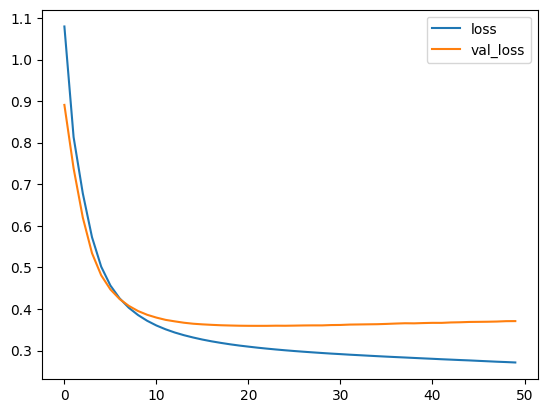

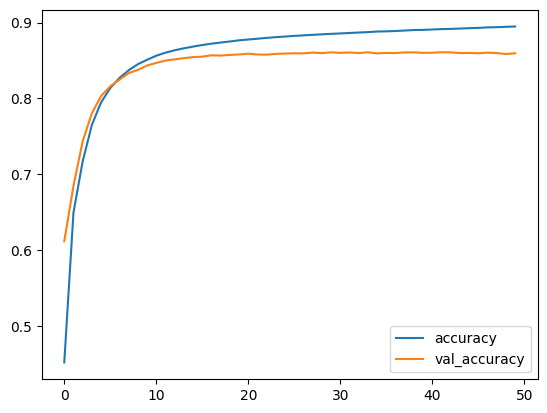

In [48]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [59]:
OUTPUT_DIR = "./savedmodels"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, 'swivel')
os.environ['EXPORT_PATH'] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.saved_model.save(swivel_model, EXPORT_PATH)

INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


Then we can deploy the model using the gcloud CLI as before:

In [56]:
%%bash

# TODO 5

MODEL_NAME=title_model
VERSION_NAME=swivel

if [[ $(gcloud ai-platform models list --format='value(name)' | grep ^$MODEL_NAME$) ]]; then
    echo "$MODEL_NAME already exists"
else
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --region=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep ^$VERSION_NAME$) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create \
  --model=$MODEL_NAME $VERSION_NAME \
  --framework=tensorflow \
  --python-version=3.7 \
  --runtime-version=2.1 \
  --origin=$EXPORT_PATH \
  --staging-bucket=gs://$BUCKET \
  --machine-type n1-standard-4 \
  --region=$REGION

Using endpoint [https://us-central1-ml.googleapis.com/]


title_model already exists


Using endpoint [https://us-central1-ml.googleapis.com/]


Creating title_model:swivel


Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.create) HttpError accessing <https://us-central1-ml.googleapis.com/v1/projects/qwiklabs-gcp-02-74c800cc1cb2/models/title_model/versions?alt=json>: response: <{'vary': 'Origin, X-Origin, Referer', 'content-type': 'application/json; charset=UTF-8', 'content-encoding': 'gzip', 'date': 'Fri, 08 Dec 2023 17:31:32 GMT', 'server': 'ESF', 'cache-control': 'private', 'x-xss-protection': '0', 'x-frame-options': 'SAMEORIGIN', 'x-content-type-options': 'nosniff', 'transfer-encoding': 'chunked', 'status': 429}>, content <{
  "error": {
    "code": 429,
    "message": "The requested number of n1-standard-4 exceeds the quota limit. Current usage/limit: 0/0, Requested: 8.",
    "status": "RESOURCE_EXHAUSTED"
  }
}
>
This may be due to network connectivity issues. Please check your network settings, and the status of the service you are trying to reach.


CalledProcessError: Command 'b'\n# TODO 5\n\nMODEL_NAME=title_model\nVERSION_NAME=swivel\n\nif [[ $(gcloud ai-platform models list --format=\'value(name)\' | grep ^$MODEL_NAME$) ]]; then\n    echo "$MODEL_NAME already exists"\nelse\n    echo "Creating $MODEL_NAME"\n    gcloud ai-platform models create --region=$REGION $MODEL_NAME\nfi\n\nif [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format=\'value(name)\' | grep ^$VERSION_NAME$) ]]; then\n    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "\n    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME\n    echo "Please run this cell again if you don\'t see a Creating message ... "\n    sleep 2\nfi\n\necho "Creating $MODEL_NAME:$VERSION_NAME"\ngcloud ai-platform versions create \\\n  --model=$MODEL_NAME $VERSION_NAME \\\n  --framework=tensorflow \\\n  --python-version=3.7 \\\n  --runtime-version=2.1 \\\n  --origin=$EXPORT_PATH \\\n  --staging-bucket=gs://$BUCKET \\\n  --machine-type n1-standard-4 \\\n  --region=$REGION\n'' returned non-zero exit status 1.

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [57]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_1_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict
./savedmodels/swivel
./savedmodels/swivel/assets
./savedmodels/swivel/assets/tokens.txt
./savedmodels/swivel/saved_model.pb
./savedmodels/swivel/variables
./savedmodels/swivel/variables/variables.data-00000-of-00001
./savedmodels/swivel/variables/variables.index


Let's go ahead and hit our model:

In [58]:
%%writefile input.json
{"keras_layer_1_input": "hello"}

Overwriting input.json


In [55]:
!gcloud ai-platform predict \
  --model title_model \
  --json-instances input.json \
  --version swivel \
  --region=$REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.predict) NOT_FOUND: Field: name Error: The specified model version was not found.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The specified model version was not found.
    field: name


## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2023 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License